In [15]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from scipy import stats # needed for ks test

from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script

# needed for editable text in svg format
plt.rcParams['svg.fonttype'] = 'none'

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


In [17]:
# load data
# set-up paths
home_dir = '/Volumes/Data/'
# home_dir = "/mnt/labNAS/"


in_path = home_dir+'Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = home_dir+'Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

# Load normalized count data - minimum intervention
with open(in_path + 'M194_M220_OMC_separate_all_count.pkl', 'rb') as f:
    omc_count = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_count.pkl', 'rb') as f:
#     aca_count = pickle.load(f)

with open(in_path + 'M194_M220_OMC_separate_all_countN.pkl', 'rb') as f:
    omc_countN = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_countN.pkl', 'rb') as f:
#     aca_countN = pickle.load(f)

In [18]:
plot_areas = ['AOMCi', 'POMCi','AOMCc', 'POMCc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'HIP', 'AMY', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']
omc_countN_cdf, foo = dfs_to_cdf(omc_countN, plot_areas=plot_areas)
omc_countN_cdf

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for HIP STF3
NO BARCODES, cannot compute ECDF for PPAGd STF3


,x,cdf,mice,species,dataset,area
0,0.000016,0.000000,MMM1,MMus,M194,AOMCi
1,0.000016,0.000000,MMM1,MMus,M194,AOMCi
2,0.000016,0.000000,MMM1,MMus,M194,AOMCi
3,0.000016,0.000000,MMM1,MMus,M194,AOMCi
4,0.000016,0.000000,MMM1,MMus,M194,AOMCi
...,...,...,...,...,...,...
995,4.756320,0.988235,STM7,STeg,M220,RN
996,4.805947,0.988235,STM7,STeg,M220,RN
997,4.856092,0.988235,STM7,STeg,M220,RN
998,4.906761,0.988235,STM7,STeg,M220,RN


# Apply Batch correction

In [19]:
# Plot by dataset - no correction
to_plot = ['AOMCi', 'POMCi','AOMCc', 'POMCc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']


In [20]:
# Calculate median BC to possibly use for batch correction (across all target regions)
targets = ['AOMCc', 'POMCc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']

medians = pd.DataFrame(columns=["AOMCi_med", "POMCi_med", "inj_med", "target_med", "all_med",
                                "mice", "species", "dataset"])


for i in range(metadata.shape[0]):
    df = omc_countN[i]

    # take nonzero median
    aomci_df = df[df['inj_site']=="AOMCi"]
    aomci = aomci_df["AOMCi"]
    aomci = aomci[aomci!=0]
    aomci_med = aomci.median()

    pomci_df = df[df['inj_site']=="POMCi"]
    pomci = pomci_df["POMCi"]
    pomci = pomci[pomci!=0]
    pomci_med = pomci.median()

    # combine AOMCi and POMCi countN for inj_med
    inj_bc = pd.concat([aomci, pomci])
    inj_med = inj_bc.median()

    # calculate median from just nonzero countN in target sites
    target_bcN = pd.Series(dtype="float64")
    
    for area in targets:
       area_bc = df[area]
       area_bc = area_bc[area_bc!=0]
       target_bcN = pd.concat([target_bcN, area_bc])

    # calculate median of nonzero countN across whole brain
    val_df = df.drop(["inj_site"], axis=1)
    vals = val_df.values.flatten()
    vals = vals[vals!=0]
    all_med = np.median(vals)
    
    target_med = target_bcN.median()

    row = [aomci_med, pomci_med, inj_med, target_med, all_med, 
           metadata.loc[i,"mice"], metadata.loc[i,"species"], metadata.loc[i,"dataset"]]

    medians.loc[i,:] = row

medians

KeyError: 'inj_site'

In [21]:
# normalize by inj_site median
omc_countN_med_inj = []
for i in range(len(omc_countN)):
    df = omc_countN[i].copy()
    df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    omc_countN_med_inj.append(df_m)



plot_cdf(omc_countN_med_inj, plot_areas=to_plot, color_by="dataset", 
         colors=["green", "purple"], title="by dataset, inj_med normed",
         fig_size=(15,15))
plt.show()

plot_cdf(omc_countN_med_inj, plot_areas=to_plot, color_by="species",
         title="by species, inj_med normed", fig_size=(15,15))
plt.show()


KeyError: "['inj_site'] not found in axis"

In [22]:
# normalize by all barcodes median
omc_countN_med = []
for i in range(len(omc_countN)):
    df = omc_countN[i].copy()
    df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "all_med"]
    omc_countN_med.append(df_m)

fig3 = plot_cdf(omc_countN_med, plot_areas=to_plot, color_by="dataset", colors=["green", "purple"],
                title="by dataset, all median normed", fig_size=(15,15))
plt.show()

fig4 = plot_cdf(omc_countN_med, plot_areas=to_plot, color_by="species",
                title="by species, all median normed", fig_size=(15,15))
plt.show()



KeyError: "['inj_site'] not found in axis"

# figs for poster

In [10]:
# Calculate median BC to possibly use for batch correction (across all target regions)
targets = ['AOMCc', 'POMCc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']

medians = pd.DataFrame(columns=["AOMCi_med", "POMCi_med", "inj_med", "target_med", "all_med",
                                "mice", "species", "dataset"])


for i in range(metadata.shape[0]):
    df = omc_countN[i]

    # take nonzero median
    aomci_df = df[df['inj_site']=="AOMCi"]
    aomci = aomci_df["AOMCi"]
    aomci = aomci[aomci!=0]
    aomci_med = aomci.median()

    pomci_df = df[df['inj_site']=="POMCi"]
    pomci = pomci_df["POMCi"]
    pomci = pomci[pomci!=0]
    pomci_med = pomci.median()

    # combine AOMCi and POMCi countN for inj_med
    inj_bc = pd.concat([aomci, pomci])
    inj_med = inj_bc.median()

    # calculate median from just nonzero countN in target sites
    target_bcN = pd.Series(dtype="float64")
    
    for area in targets:
       area_bc = df[area]
       area_bc = area_bc[area_bc!=0]
       target_bcN = pd.concat([target_bcN, area_bc])

    # calculate median of nonzero countN across whole brain
    val_df = df.drop(["inj_site"], axis=1)
    vals = val_df.values.flatten()
    vals = vals[vals!=0]
    all_med = np.median(vals)
    
    target_med = target_bcN.median()

    row = [aomci_med, pomci_med, inj_med, target_med, all_med, 
           metadata.loc[i,"mice"], metadata.loc[i,"species"], metadata.loc[i,"dataset"]]

    medians.loc[i,:] = row

medians

,AOMCi_med,POMCi_med,inj_med,target_med,all_med,mice,species,dataset
0,0.007197,0.006575,0.006733,0.001943,0.002065,MMM1,MMus,M194
1,0.00629,0.005647,0.005953,0.001554,0.001568,MMF2,MMus,M194
2,0.011171,0.008818,0.009122,0.001858,0.00213,MMF3,MMus,M194
3,0.022893,0.023409,0.022905,0.002171,0.002253,STM1,STeg,M194
4,0.023799,0.017385,0.023192,0.002824,0.002676,STM2,STeg,M194
5,0.021982,0.013172,0.019628,0.00232,0.002359,STF3,STeg,M194
6,0.124483,0.116321,0.119496,0.052,0.042,MMM4,MMus,M220
7,0.083029,0.050412,0.058168,0.052189,0.037809,MMF5,MMus,M220
8,0.35396,0.213559,0.270012,0.05547,0.055879,STF4,STeg,M220
9,0.222513,0.225242,0.224694,0.108247,0.075486,STM5,STeg,M220


In [11]:
to_plot = ['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 
           'SCm', 'PG', 'PAG', 'RN']

# combine areas
omc_countN_comb = df_combine_areas(omc_countN)


# normalize by all barcodes median
omc_countN_med = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "all_med"]
    omc_countN_med.append(df_m)

# normalize by inj barcodes median
omc_countN_med_inj = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    omc_countN_med_inj.append(df_m)


In [12]:
# omc_countN_rename = [df.rename(columns={"AUD":"AUD/TEa"}) for df in omc_countN_med]
# omc_countN_rename[0]

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


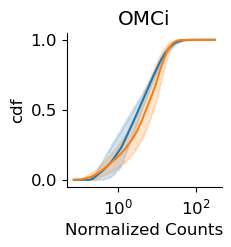

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


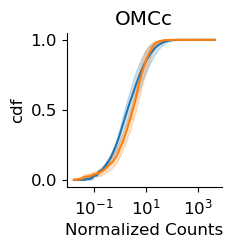

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


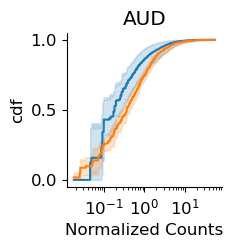

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


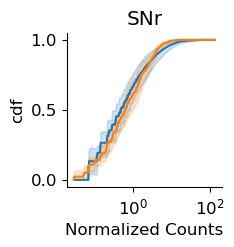

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


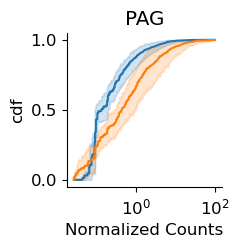

In [16]:
plot_ind = [["OMCi"], ["OMCc"], ["AUD"], ["SNr"], ["PAG"]]
labels = ["OMCi", "OMCc", "AUD", "SNr", "PAG"]

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(omc_countN_med, plot_areas=area, color_by="species", title=None, legend=False, 
             individual=False, fig_size=(2,2))
    plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95.svg", dpi=300, bbox_inches="tight")
    plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the s

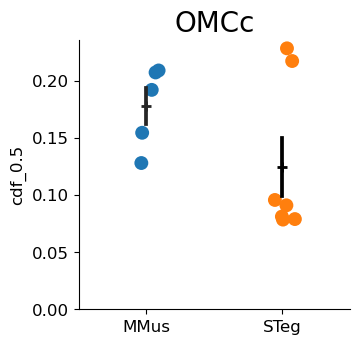

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


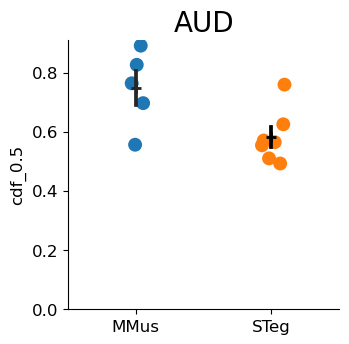

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


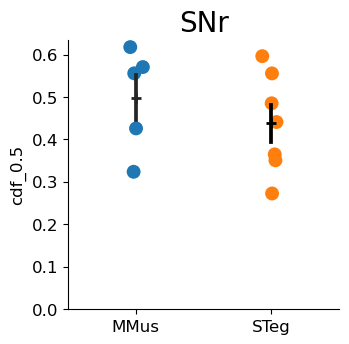

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


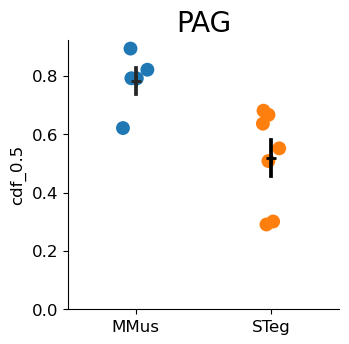

In [13]:
areas = ["OMCc", "AUD", "SNr", "PAG"]

cdf5_df = calc_cdf(omc_countN_med, plot_areas=areas, cdf_val=0.5)

for area in areas:
    dot_plot(cdf5_df, area=area, title=area, to_plot="cdf_0.5")
    # plt.savefig(out_path+"cdf5_"+area+"dotplot.svg", dpi=300, bbox_inches="tight")
    plt.show()

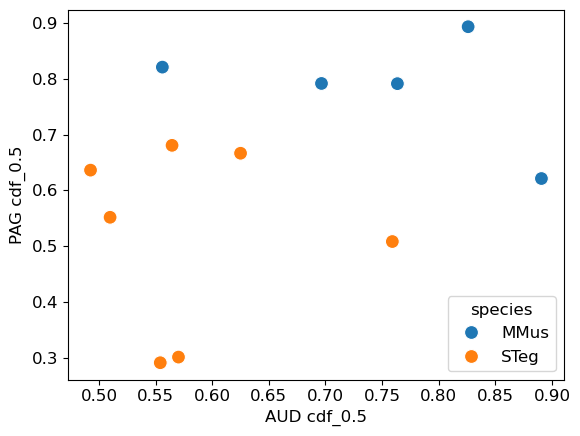

In [26]:
cdf5_aud = cdf5_df[cdf5_df['area']=="AUD"].reset_index(drop=True)
cdf5_pag = cdf5_df[cdf5_df['area']=="PAG"].reset_index(drop=True)
cdf5_sc = cdf5_aud.copy().drop(['area'],axis=1)
cdf5_sc = cdf5_sc.rename(columns={"cdf_0.5":"aud_cdf5"})
cdf5_sc['pag_cdf5'] = cdf5_pag['cdf_0.5']

sns.scatterplot(cdf5_sc, x="aud_cdf5", y="pag_cdf5", hue="species",
                s=100)
plt.xlabel("AUD cdf_0.5")
plt.ylabel("PAG cdf_0.5")

plt.savefig(out_path+"omc_cdf5_AUDvPAG.svg", dpi=300, bbox_inches="tight")

plt.show()

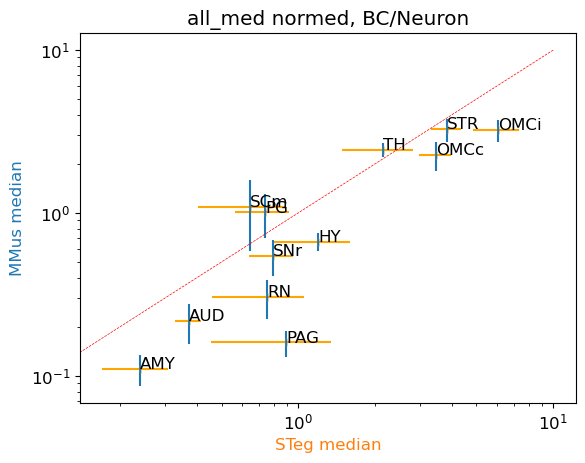

In [ ]:
# # scatter and volcano
# # normalize by all BC median


# # to_drop = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']
# plot_med = dfs_to_medians(omc_countN_med, drop=[])
# stvmm_area_scatter(plot_med, to_plot="median", log=True, title="all_med normed, BC/Neuron", line_up_limit=10)
# plt.savefig(out_path+"scatter_comb_all_med.jpg", dpi=200, bbox_inches="tight")
# plt.show()


In [24]:
plot

,area,p-value,MMus_mean,STeg_mean,fold_change,log2_fc,nlog10_p,p<0.05
0,AMY,0.430776,0.036006,0.068546,1.903746,0.928841,0.365749,False
1,AUD,0.626638,0.067765,0.085262,1.258199,0.331360,0.202983,False
2,HY,0.597591,0.224930,0.192832,0.857298,-0.222132,0.223596,False
3,OMCc,0.881034,0.913857,0.991355,1.084804,0.117434,0.055007,False
4,OMCi,0.161333,1.023907,1.057967,1.033265,0.047210,0.792278,False
5,PAG,0.236251,0.061439,0.274045,4.460429,2.157182,0.626627,False
6,PG,0.354993,0.371134,0.225225,0.606856,-0.720574,0.449780,False
7,RN,0.428632,0.092604,0.266420,2.876973,1.524552,0.367916,False
8,SCm,0.256377,0.491364,0.198271,0.403512,-1.309315,0.591121,False
9,SNr,0.847123,0.206702,0.233452,1.129413,0.175573,0.072054,False


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:762: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


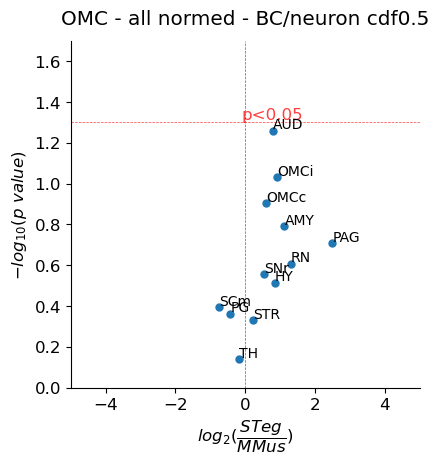

In [31]:

# volcano
plot_med = dfs_to_medians(omc_countN_med, drop=[])
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, p_01=False, title="OMC - all normed - BC/neuron cdf0.5", xlim=(-5,5), legend_loc=None,
             fig_size=(4.5,4.5))

plt.savefig(out_path+"volcano_comb_inj_med.svg", dpi=300, bbox_inches="tight")
plt.show()

# scatter and volcano
- can only compare 2 samples at a time w/ KS
- decided to look at median per area so can compare across groups

## NO NORMALIZATION

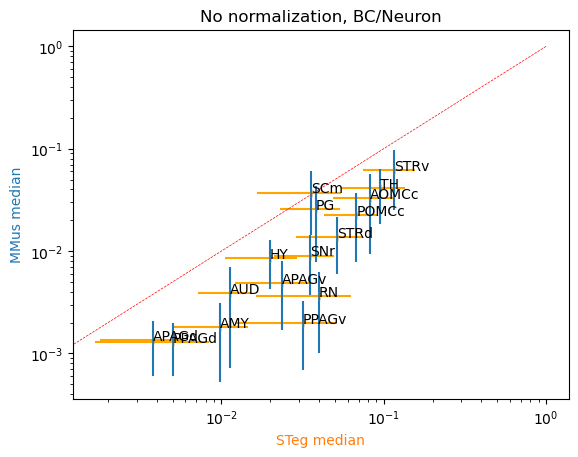

posx and posy should be finite values
posx and posy should be finite values


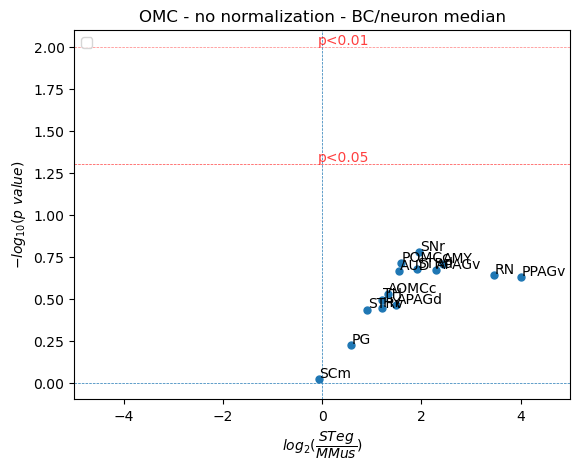

In [84]:
plot_med = dfs_to_medians(omc_countN)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="No normalization, BC/Neuron")
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="OMC - no normalization - BC/neuron median", xlim=(-5,5))
plt.show()

## Median Normalized

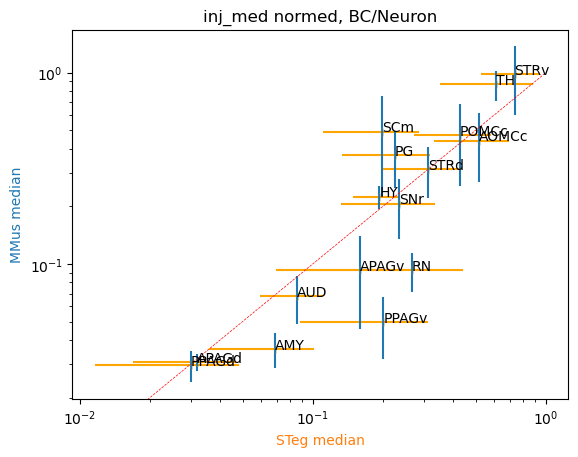

posx and posy should be finite values
posx and posy should be finite values


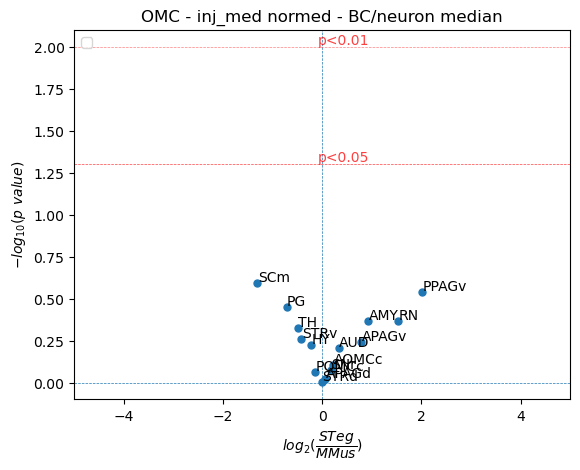

In [104]:
# normalize by inj_site median
omc_countN_med = []
for i in range(len(omc_countN)):
    df = omc_countN[i].copy()
    df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    omc_countN_med.append(df_m)

to_drop = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']
plot_med = dfs_to_medians(omc_countN_med, drop=to_drop)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="inj_med normed, BC/Neuron")
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="OMC - inj_med normed - BC/neuron median", xlim=(-5,5))
plt.show()

## w/in dataset

In [90]:
m194 = []
m220 = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"dataset"]=="M194":
        m194.append(omc_countN[i])
    elif metadata.loc[i,"dataset"]=="M220":
        m220.append(omc_countN[i])

6

### M194

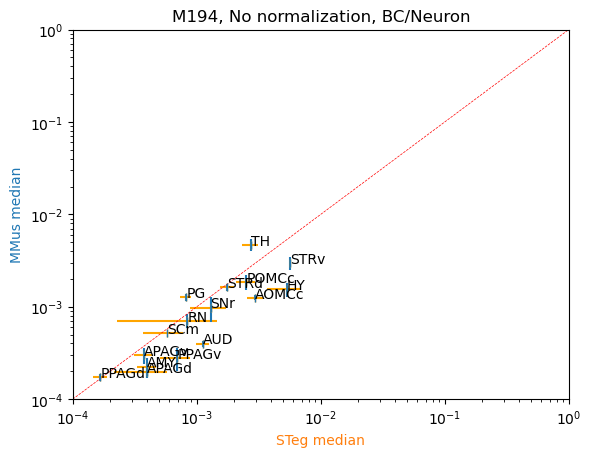

posx and posy should be finite values
posx and posy should be finite values


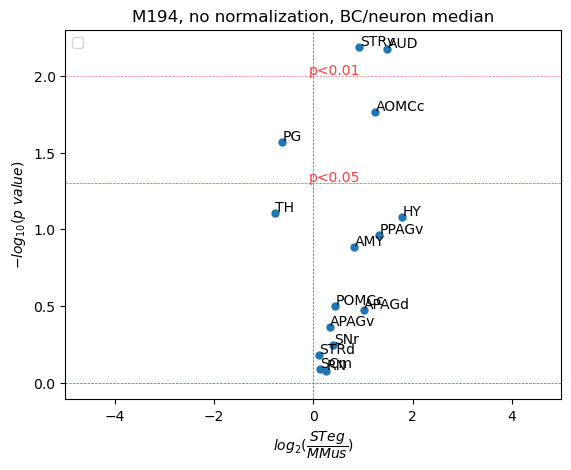

In [99]:
plot_med = dfs_to_medians(m194)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="M194, No normalization, BC/Neuron", 
                   ax_limits=(0.0001, 1))
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="M194, no normalization, BC/neuron median", xlim=(-5,5))
plt.show()

### M220

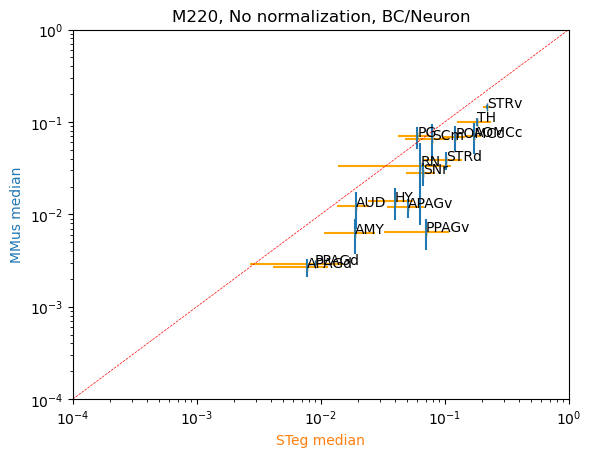

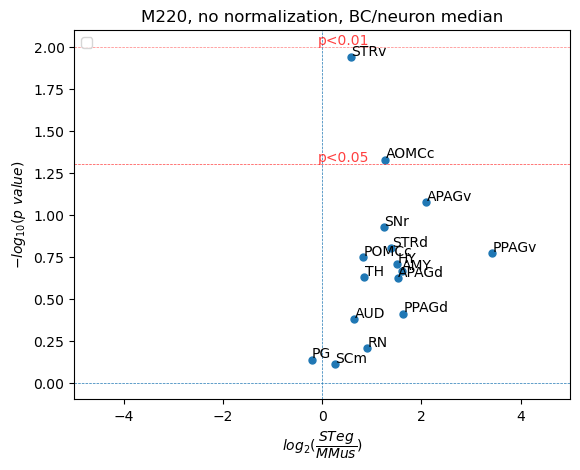

In [100]:
plot_med = dfs_to_medians(m220)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="M220, No normalization, BC/Neuron",
                   ax_limits=(0.0001, 1))
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="M220, no normalization, BC/neuron median", xlim=(-5,5))
plt.show()